In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "yourpath/data_stream-oper_stepType-instant.nc"
ds = xr.open_dataset(file_path)

In [4]:
variables = ['z','t','u','v', 'q']
level = 0
time_window = 40
target_variable = 'z'
selected_year = 2020

ds_year = ds.sel(valid_time=ds.valid_time.where(ds.valid_time.dt.year == selected_year, drop=True))

T_total = len(ds_year.valid_time)
H = len(ds_year.latitude)
W = len(ds_year.longitude)
C = len(variables)

print(f"Total time steps: {T_total}, Height: {H}, Width: {W}, Channels: {C}")

Total time steps: 368, Height: 201, Width: 281, Channels: 5


In [5]:
batch_size = 100
sample_indices = list(range(time_window, T_total))
print(f"총 선택된 샘플 수: {len(sample_indices)}")

X_batch = []
y_batch = []
valid_time_batch = []

file_path = '/content/drive/MyDrive/[2025-1]_리빙랩'  # 저장 경로
os.makedirs(file_path, exist_ok=True)

existing_files = sorted([f for f in os.listdir(file_path) if f.startswith('X_part')])
if existing_files:
    last_file = existing_files[-1]
    last_part_num = int(last_file.split('X_part')[-1].split('.npy')[0])
    X_batch = list(np.load(os.path.join(file_path, f'X_part{last_part_num}.npy')))
    y_batch = list(np.load(os.path.join(file_path, f'y_part{last_part_num}.npy')))
    valid_time_batch = list(np.load(os.path.join(file_path, f'valid_times_part{last_part_num}.npy')))
    start_idx = time_window + last_part_num * batch_size
    sample_indices = sample_indices[last_part_num * batch_size:] if last_part_num * batch_size < len(sample_indices) else []
    print(f"이어서 처리 시작: 인덱스 {start_idx}")
    part_num = last_part_num
else:
    part_num = 0


총 선택된 샘플 수: 328
이어서 처리 시작: 인덱스 440


In [ ]:
import numpy as np

x_path = 'yourpath/X_full_(z,t,u,v,q).npy'
x = np.load(x_path)
print(x.shape)


(328, 40, 5, 201, 281)


In [7]:
import torch
from torch.utils.data import Dataset
import numpy as np

class ERA5LazyDataset(Dataset):
    def __init__(self, x_file, y_file, start_idx=0, end_idx=None):
        self.x_file = x_file
        self.y_file = y_file
        self.x_data = np.load(x_file, mmap_mode='r')
        self.y_data = np.load(y_file, mmap_mode='r')
        self.g = 9.80665

        self.variables = ['z', 't', 'u', 'v', 'q']

        self.norm_dict = {
            'z': (5880, 100),
            't': (270, 15),
            'u': (0.0, 20.0),
            'v': (0.0, 20.0),
            'q': (0.005, 0.003),
        }

        self.start_idx = start_idx
        self.end_idx = end_idx if end_idx is not None else self.x_data.shape[0]
        assert 0 <= self.start_idx < self.end_idx <= self.x_data.shape[0]

        self.length = self.end_idx - self.start_idx

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        real_idx = self.start_idx + idx

        x = self.x_data[real_idx].copy()
        y = self.y_data[real_idx].copy()
        x[:, 0, :, :] = x[:, 0, :, :] / self.g
        y = y / self.g

        for i, var in enumerate(self.variables):
            mean, std = self.norm_dict[var]
            x[:, i, :, :] = (x[:, i, :, :] - mean) / std

        y = (y - self.norm_dict['z'][0]) / self.norm_dict['z'][1]

        x_tensor = torch.tensor(x, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0)

        return x_tensor, y_tensor


In [ ]:
x_file = "yourpath/X_full_(z,t,u,v,q).npy"
y_file = "yourpath/y_full_(z,t,u,v,q).npy"

total_len = np.load(x_file, mmap_mode='r').shape[0]
split_idx = int(total_len * 0.8)

train_dataset = ERA5LazyDataset(x_file, y_file, start_idx=0, end_idx=split_idx)
val_dataset = ERA5LazyDataset(x_file, y_file, start_idx=split_idx, end_idx=total_len)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

x_batch, y_batch = next(iter(train_loader))
print("x shape:", x_batch.shape)
print("y shape:", y_batch.shape)


x shape: torch.Size([5, 40, 5, 201, 281])
y shape: torch.Size([5, 1, 201, 281])


In [9]:

X_train = np.random.rand(40, 10, 5, 201, 281).astype(np.float32)
y_train = np.random.rand(40, 201, 281).astype(np.float32)
X_val = np.random.rand(10, 10, 5, 201, 281).astype(np.float32)
y_val = np.random.rand(10, 201, 281).astype(np.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).to(device)
y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(X_val).to(device)
y_val_tensor = torch.tensor(y_val).unsqueeze(1).to(device)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [11]:

X_train = np.random.rand(40, 10, 5, 201, 281).astype(np.float32)
y_train = np.random.rand(40, 201, 281).astype(np.float32)
X_val = np.random.rand(10, 10, 5, 201, 281).astype(np.float32)
y_val = np.random.rand(10, 201, 281).astype(np.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).to(device)
y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(X_val).to(device)
y_val_tensor = torch.tensor(y_val).unsqueeze(1).to(device)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class SpatialEncoderUNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.pool3 = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool1(x1))
        x3 = self.conv3(self.pool2(x2))
        bottleneck = self.pool3(x3)
        return bottleneck, x1, x2, x3

class UNetGRUModel(nn.Module):
    def __init__(self, in_channels=4, hidden_dim=256, out_shape=(201,281)):
        super().__init__()
        self.spatial_encoder = SpatialEncoderUNet(in_channels)
        self.fc = nn.Linear(64, hidden_dim)
        self.temporal_encoder = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        # decoder layers
        self.up1 = nn.ConvTranspose2d(hidden_dim, 64, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.Sequential(nn.Conv2d(64+64, 64, 3, padding=1), nn.ReLU(inplace=True))
        self.up2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Sequential(nn.Conv2d(32+32, 32, 3, padding=1), nn.ReLU(inplace=True))
        self.up3 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.conv3 = nn.Sequential(nn.Conv2d(16+16, 16, 3, padding=1), nn.ReLU(inplace=True))
        self.up4 = nn.ConvTranspose2d(16, 8, 4, stride=4)
        self.conv4 = nn.Sequential(nn.Conv2d(8, 8, 3, padding=1), nn.ReLU(inplace=True))
        self.final_conv = nn.Conv2d(8, 1, 1)
        self.out_H, self.out_W = out_shape

    def forward(self, x):
        B, T, C, H, W = x.shape
        x_flat = x.view(B*T, C, H, W)
        bottleneck, skip1, skip2, skip3 = self.spatial_encoder(x_flat)
        skip1 = skip1.view(B, T, *skip1.shape[1:])[:, -1]
        skip2 = skip2.view(B, T, *skip2.shape[1:])[:, -1]
        skip3 = skip3.view(B, T, *skip3.shape[1:])[:, -1]
        feat = bottleneck.view(B*T, -1)
        feat = self.fc(feat).view(B, T, -1)
        _, h = self.temporal_encoder(feat)
        h = h.squeeze(0).unsqueeze(-1).unsqueeze(-1)
        d1 = self.up1(h)
        s3 = F.interpolate(skip3, size=d1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.conv1(torch.cat([d1, s3], dim=1))
        d2 = self.up2(d1)
        s2 = F.interpolate(skip2, size=d2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.conv2(torch.cat([d2, s2], dim=1))
        d3 = self.up3(d2)
        s1 = F.interpolate(skip1, size=d3.shape[2:], mode='bilinear', align_corners=False)
        d3 = self.conv3(torch.cat([d3, s1], dim=1))
        d4 = self.up4(d3)
        d4 = self.conv4(d4)
        out = self.final_conv(d4)
        out = F.interpolate(out, size=(self.out_H, self.out_W), mode='bilinear', align_corners=False)
        return out

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

input_channels = len(variables)
model = UNetGRUModel(in_channels=5).to(device)


criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
output = model(X_train_tensor)
print("Output shape:", output.shape)

Device: cuda
Output shape: torch.Size([40, 1, 201, 281])


In [14]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
import torch.nn.functional as F

num_epochs = 10
batch_size = 4

train_losses = []
val_losses = []

pred_list = []
actual_list = []
error_list = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training"):
          x, y = x.to(device), y.to(device)

          optimizer.zero_grad()
          pred = model(x)
          pred_resized = F.interpolate(pred, size=(y.size(2), y.size(3)), mode='bilinear', align_corners=False)
          loss = criterion(pred_resized, y)

          loss.backward()
          optimizer.step()

          running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            pred_resized = F.interpolate(pred, size=(y.size(2), y.size(3)), mode='bilinear', align_corners=False)
            loss = criterion(pred_resized, y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/10 Training: 100%|██████████| 53/53 [00:41<00:00,  1.26it/s]


Epoch 1 - Train Loss: 1.7856, Val Loss: 2.0401


Epoch 2/10 Training: 100%|██████████| 53/53 [00:26<00:00,  2.02it/s]


Epoch 2 - Train Loss: 1.1510, Val Loss: 0.5527


Epoch 3/10 Training: 100%|██████████| 53/53 [00:26<00:00,  2.01it/s]


Epoch 3 - Train Loss: 0.3998, Val Loss: 0.4594


Epoch 4/10 Training: 100%|██████████| 53/53 [00:26<00:00,  2.00it/s]


Epoch 4 - Train Loss: 0.3286, Val Loss: 0.3907


Epoch 5/10 Training: 100%|██████████| 53/53 [00:26<00:00,  2.00it/s]


Epoch 5 - Train Loss: 0.2691, Val Loss: 0.3505


Epoch 6/10 Training: 100%|██████████| 53/53 [00:26<00:00,  2.00it/s]


Epoch 6 - Train Loss: 0.2296, Val Loss: 0.3260


Epoch 7/10 Training: 100%|██████████| 53/53 [00:26<00:00,  2.00it/s]


Epoch 7 - Train Loss: 0.2004, Val Loss: 0.3248


Epoch 8/10 Training: 100%|██████████| 53/53 [00:26<00:00,  1.98it/s]


Epoch 8 - Train Loss: 0.1801, Val Loss: 0.2687


Epoch 9/10 Training: 100%|██████████| 53/53 [00:26<00:00,  2.01it/s]


Epoch 9 - Train Loss: 0.1568, Val Loss: 0.2298


Epoch 10/10 Training: 100%|██████████| 53/53 [00:26<00:00,  1.99it/s]


Epoch 10 - Train Loss: 0.1367, Val Loss: 0.1962


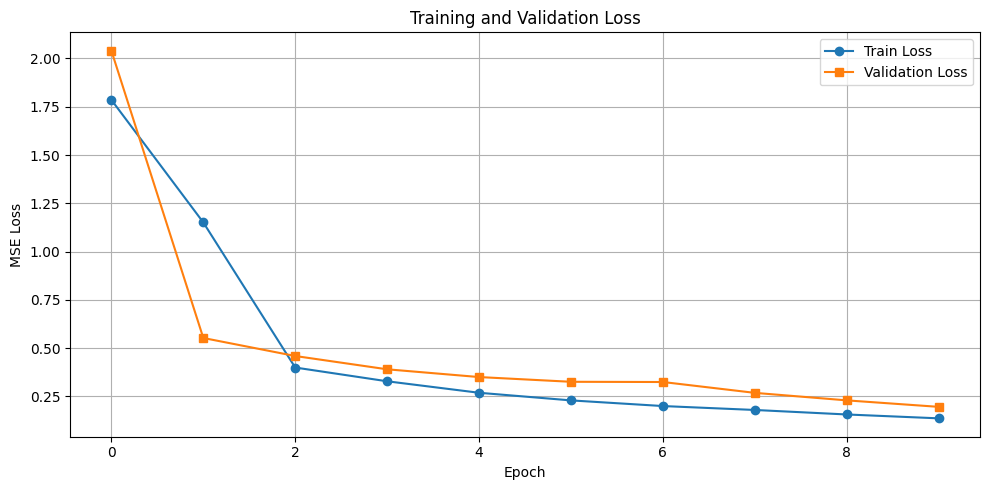

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
pred_list = []
actual_list = []
error_list = []

model.eval()

with torch.no_grad():
    for i in tqdm(range(len(val_loader.dataset))):

        x_sample = val_dataset[i][0].unsqueeze(0).to(device)
        y_true = val_dataset[i][1][0].cpu().numpy()

        y_pred_norm = model(x_sample).cpu().numpy()[0, 0]

        z_mean, z_std = 5880, 100


        pred_height = y_pred_norm * z_std + z_mean
        actual_height = y_true * z_std + z_mean
        abs_error = np.abs(pred_height - actual_height)

        pred_list.append(pred_height)
        actual_list.append(actual_height)
        error_list.append(abs_error)

100%|██████████| 66/66 [00:07<00:00,  8.58it/s]


In [ ]:

file_path = 'yourpath'

valid_time_file = os.path.join(file_path, 'valid_times_full_(z,t,u,v,q).npy')
val_time_raw = np.load(valid_time_file)

print(f"총 valid_time 수: {len(val_time_raw)}")


총 valid_time 수: 328


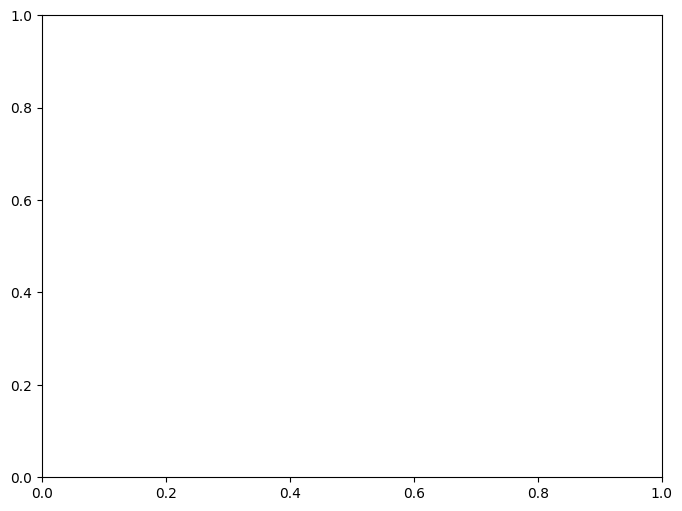

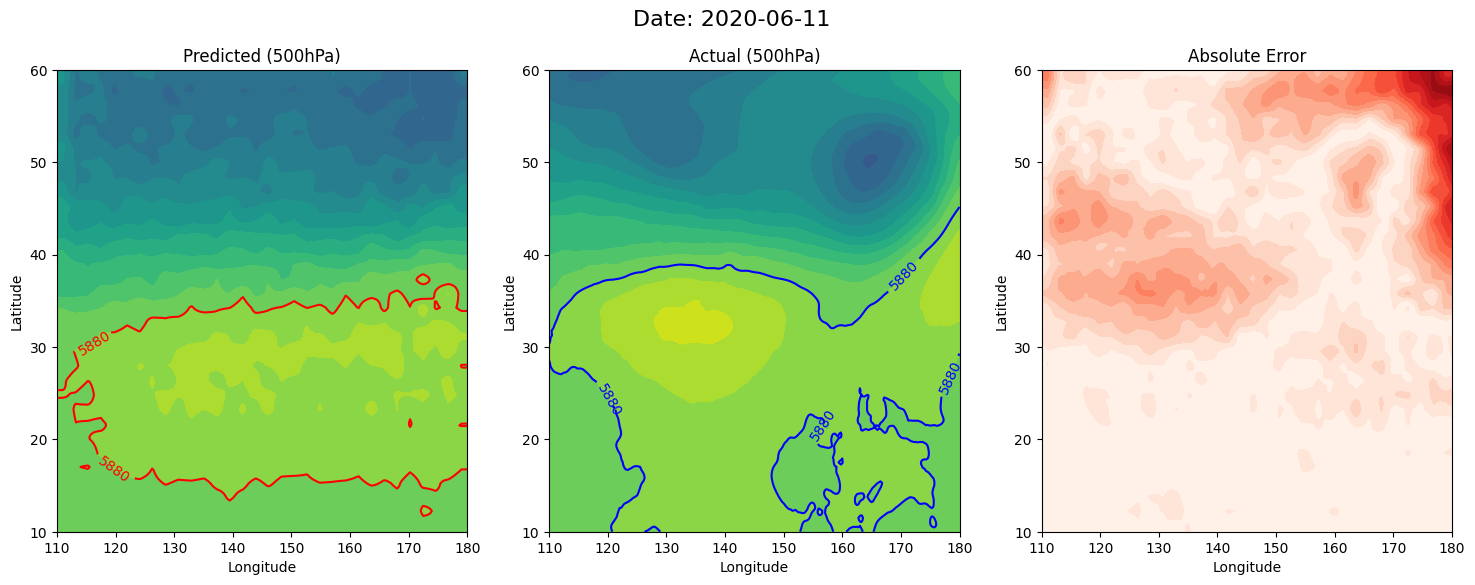

In [18]:

z = ds['z'].sel(pressure_level=500)
time = ds['valid_time'].values
lat = ds['latitude'].values
lon = ds['longitude'].values
z = z / 9.80665

fig, ax = plt.subplots(figsize=(8, 6))
lon2d, lat2d = np.meshgrid(lon, lat)

val_time = [pd.to_datetime(str(t)) for t in val_time_raw]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
levels = np.linspace(5400, 6000, 21)
contour_level = [5880]
def update(frame):
    for ax in axes:
        ax.clear()

    pred = pred_list[frame]
    actual = actual_list[frame]
    err = error_list[frame]

    cf0 = axes[0].contourf(lon2d, lat2d, pred, levels=levels, cmap='viridis')
    cl0 = axes[0].contour(lon2d, lat2d, pred, levels=contour_level, colors='red')
    axes[0].clabel(cl0, fmt={5880: '5880'}, colors='red')
    axes[0].set_title("Predicted (500hPa)")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    cf1 = axes[1].contourf(lon2d, lat2d, actual, levels=levels, cmap='viridis')
    cl1 = axes[1].contour(lon2d, lat2d, actual, levels=contour_level, colors='blue')
    axes[1].clabel(cl1, fmt={5880: '5880'}, colors='blue')
    axes[1].set_title("Actual (500hPa)")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    cf2 = axes[2].contourf(lon2d, lat2d, err, levels=20, cmap='Reds')
    axes[2].set_title("Absolute Error")
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Latitude")

    fig.suptitle(f"Date: {val_time[frame].strftime('%Y-%m-%d')}", fontsize=16)

ani = animation.FuncAnimation(fig, update, frames=len(pred_list), interval=300, blit=False)


In [ ]:
gif_save_path = "yourpath/UNet-GRU('z','t','u','v','q'_예측_실제_오차_비교_지도스타일.gif"
ani.save(gif_save_path, writer='pillow', fps=3)

print("GIF 저장 완료:", gif_save_path)

GIF 저장 완료: /content/drive/MyDrive/[2025-1]_리빙랩/UNet-GRU('z','t','u','v','q'_예측_실제_오차_비교_지도스타일.gif


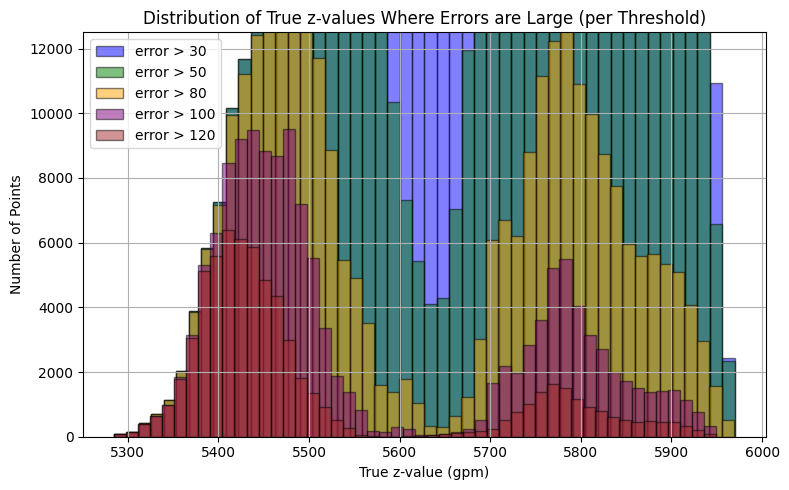

In [20]:
plt.rcParams['font.family'] = 'DejaVu Sans'

thresholds = [30,50,80,100,120]
z_distributions = {thr: [] for thr in thresholds}

for pred, actual in zip(pred_list, actual_list):
    error = np.abs(pred - actual)
    for thr in thresholds:
        mask = error > thr
        z_vals = actual[mask]
        z_distributions[thr].append(z_vals)

for thr in thresholds:
    z_distributions[thr] = np.concatenate(z_distributions[thr])

plt.figure(figsize=(8, 5))
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'red']

for thr, color in zip(thresholds, colors):
    plt.hist(z_distributions[thr], bins=50, alpha=0.5,
             label=f'error > {thr}', color=color, edgecolor='black')

plt.title("Distribution of True z-values Where Errors are Large (per Threshold)")
plt.xlabel("True z-value (gpm)")
plt.ylabel("Number of Points")
plt.ylim(0,12500)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
!pip install shapely


pred_mask sum: 15859
actual_mask sum: 11540


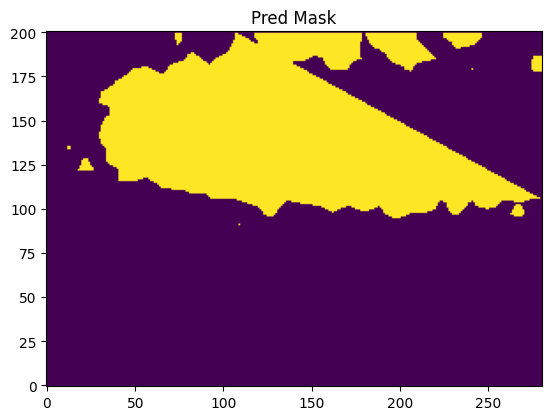

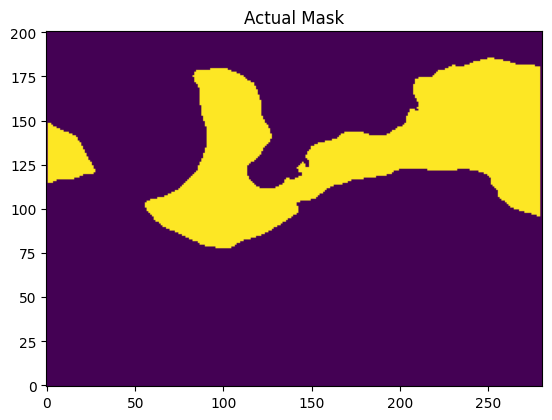

In [22]:
pred_contours = plt.contour(lon2d, lat2d, pred, levels=[5880])
actual_contours = plt.contour(lon2d, lat2d, actual, levels=[5880])

def create_mask_from_contours(contours, lon2d, lat2d):
    from matplotlib.path import Path

    mask = np.zeros_like(lon2d, dtype=bool)

    for seg in contours:
        path = Path(seg)
        points = np.vstack((lon2d.flatten(), lat2d.flatten())).T
        inside = path.contains_points(points).reshape(lon2d.shape)
        mask |= inside

    return mask


pred_mask = create_mask_from_contours(pred_contours.allsegs[0], lon2d, lat2d)
actual_mask = create_mask_from_contours(actual_contours.allsegs[0], lon2d, lat2d)

print("pred_mask sum:", pred_mask.sum())
print("actual_mask sum:", actual_mask.sum())

plt.imshow(pred_mask, origin='lower')
plt.title("Pred Mask")
plt.show()

plt.imshow(actual_mask, origin='lower')
plt.title("Actual Mask")
plt.show()


In [23]:
def calculate_iou(pred, actual, lon2d, lat2d, contour_level=5880):
    from matplotlib.path import Path

    pred_contours = plt.contour(lon2d, lat2d, pred, levels=[contour_level])
    actual_contours = plt.contour(lon2d, lat2d, actual, levels=[contour_level])
    plt.close()

    def create_mask_from_contours(contours, lon2d, lat2d):
        mask = np.zeros_like(lon2d, dtype=bool)
        for seg in contours:
            path = Path(seg)
            points = np.vstack((lon2d.flatten(), lat2d.flatten())).T
            inside = path.contains_points(points).reshape(lon2d.shape)
            mask |= inside
        return mask

    if len(pred_contours.allsegs[0]) == 0 or len(actual_contours.allsegs[0]) == 0:
        return 0.0

    pred_mask = create_mask_from_contours(pred_contours.allsegs[0], lon2d, lat2d)
    actual_mask = create_mask_from_contours(actual_contours.allsegs[0], lon2d, lat2d)

    intersection = np.logical_and(pred_mask, actual_mask).sum()
    union = np.logical_or(pred_mask, actual_mask).sum()

    if union == 0:
        return 0.0

    return intersection / union


In [24]:
iou_scores = []
val_time_plot = []

for frame in range(len(pred_list)):
    pred = pred_list[frame]
    actual = actual_list[frame]
    iou = calculate_iou(pred, actual, lon2d, lat2d, contour_level=5880)
    iou_scores.append(iou)
    val_time_plot.append(val_time[frame])


for t, iou in zip(val_time, iou_scores):
    print(f"{t.strftime('%Y-%m-%d')}: IOU = {iou:.4f}")


2020-06-11: IOU = 0.1209
2020-06-11: IOU = 0.2599
2020-06-11: IOU = 0.4364
2020-06-11: IOU = 0.1980
2020-06-12: IOU = 0.2843
2020-06-12: IOU = 0.2243
2020-06-12: IOU = 0.4286
2020-06-12: IOU = 0.2511
2020-06-13: IOU = 0.3394
2020-06-13: IOU = 0.2711
2020-06-13: IOU = 0.3609
2020-06-13: IOU = 0.2607
2020-06-14: IOU = 0.2397
2020-06-14: IOU = 0.2758
2020-06-14: IOU = 0.5282
2020-06-14: IOU = 0.2468
2020-06-15: IOU = 0.2737
2020-06-15: IOU = 0.2085
2020-06-15: IOU = 0.3323
2020-06-15: IOU = 0.2800
2020-06-16: IOU = 0.3544
2020-06-16: IOU = 0.3030
2020-06-16: IOU = 0.2159
2020-06-16: IOU = 0.2696
2020-06-17: IOU = 0.1175
2020-06-17: IOU = 0.3359
2020-06-17: IOU = 0.1684
2020-06-17: IOU = 0.3107
2020-06-18: IOU = 0.1964
2020-06-18: IOU = 0.2862
2020-06-18: IOU = 0.3830
2020-06-18: IOU = 0.1640
2020-06-19: IOU = 0.3318
2020-06-19: IOU = 0.0916
2020-06-19: IOU = 0.3923
2020-06-19: IOU = 0.2230
2020-06-20: IOU = 0.4143
2020-06-20: IOU = 0.3751
2020-06-20: IOU = 0.1515
2020-06-20: IOU = 0.4584


In [25]:
import numpy as np

valid_ious = [iou for iou in iou_scores if not np.isnan(iou)]

if valid_ious:
    mean_iou = np.mean(valid_ious)
    print(f"평균 IOU (NaN 제외): {mean_iou:.4f}")
else:
    print("유효한 IOU 값이 없습니다.")


평균 IOU (NaN 제외): 0.3017


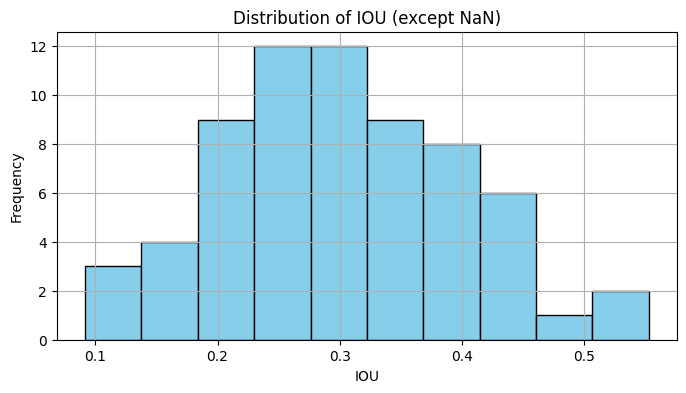

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(valid_ious, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of IOU (except NaN)")
plt.xlabel("IOU")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


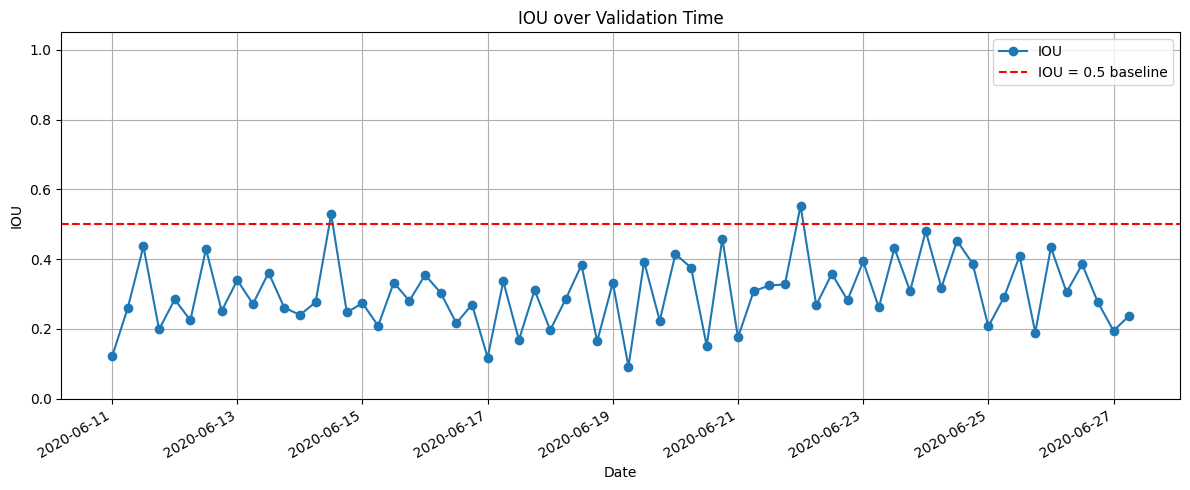

In [27]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 5))
plt.plot(val_time_plot, iou_scores, marker='o', linestyle='-', label='IOU')
plt.axhline(y=0.5, color='r', linestyle='--', label='IOU = 0.5 baseline')

plt.title('IOU over Validation Time')
plt.xlabel('Date')
plt.ylabel('IOU')
plt.ylim(0, 1.05)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plt.savefig("yourpath/iou_timeseries_UNet-GRU_z_t_u_v_q.png", dpi=300)

<Figure size 640x480 with 0 Axes>

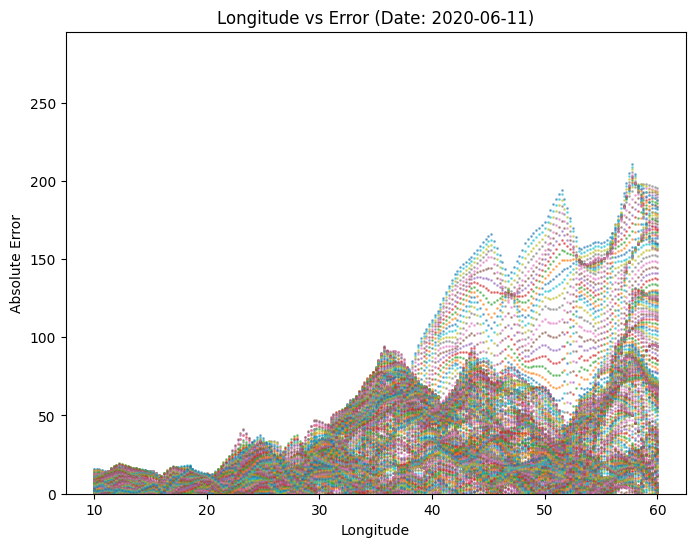

In [29]:

all_errors = np.stack(error_list)
ymin = all_errors.min()
ymax = all_errors.max()

fig_error, ax_error = plt.subplots(figsize=(8, 6))

def update(frame):
    for ax in axes:
        ax.clear()

    pred = pred_list[frame]
    actual = actual_list[frame]
    err = error_list[frame]


    cf2 = axes[2].contourf(lon2d, lat2d, err, levels=20, cmap='Reds')
    axes[2].set_title("Absolute Error")
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Latitude")

    ax_error.clear()
    ax_error.set_ylim(ymin, ymax)

    ax_error.set_title(f"Longitude vs Error (Date: {val_time[frame].strftime('%Y-%m-%d')})")
    ax_error.set_xlabel("Longitude")
    ax_error.set_ylabel("Absolute Error")

    for j in range(len(lon)):
         ax_error.plot(lat, err[:, j], '.', alpha=0.5, markersize=2)

    fig.suptitle(f"Date: {val_time[frame].strftime('%Y-%m-%d')}", fontsize=16)

ani_main = animation.FuncAnimation(fig, update, frames=len(pred_list), interval=300, blit=False)
ani_error = animation.FuncAnimation(fig_error, update, frames=len(pred_list), interval=300, blit=False)

In [ ]:
gif_save_path = "yourpath/UNet-GRU('z','t','u','v','q')산점도-경도.gif"
ani_error.save(gif_save_path, writer='pillow', fps=3)

print("GIF 저장 완료:", gif_save_path)